In [26]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown
from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from numpy import array
from sklearn.model_selection import KFold

nltk.download('brown')
nltk.download('universal_tagset')

total = len(brown.tagged_sents())
tags = 'universal'
train_size = int(total * 0.8)
test_size = total - train_size
sent = brown.tagged_sents(tagset = tags)[:]

w2v_words = Word2Vec(brown.sents(), size=30)

tags_list = list(set([tag for (_, tag) in brown.tagged_words(tagset=tags)]))
print(tags_list)


tags_list = ['ADJ','CONJ','NOUN','.','X','NUM','ADP','VERB','PRON','DET','PRT','ADV','<s>','</s>']

i=0
tags={}
for x in tags_list:
    tags[x]=i
    i=i+1
    
# ////////////////////////////////////////////////

def onehot(n, l):
    ohot = np.zeros(l)
    ohot[n] = 1
    return ohot


def gradient_loss_vectorised(wt, x_train, y, reg):
   
    LOSS = 0.0
    DELTA = 1.0

    train_num = y.shape[0]
    current_label = wt.dot(x_train)
 
    actual_class = current_label[y, range(train_num)] 
    
    difference = current_label - actual_class + DELTA

    difference = np.maximum(0, difference)
    difference[y, range(train_num)] = 0

    LOSS = np.sum(difference) / train_num

    LOSS = LOSS + 0.5 * reg * np.sum(wt * wt)

    current_gradient_label = np.zeros(current_label.shape)

    pos_num = np.sum(difference > 0, axis=0)
    current_gradient_label[difference > 0] = 1
    current_gradient_label[y, range(train_num)] = -1 * pos_num

    delta_W = current_gradient_label.dot(x_train.T) / train_num + reg * wt
    
    return LOSS, delta_W



def svm_features(wid, sentences, word2vec,tags):
    feat = []
    keys = word2vec.wv.vocab.keys()

    words_prev_n = 2
    for i in reversed(range(0,words_prev_n+1)):
        if sentences[wid-i][0] not in keys:
            vec = np.zeros(word2vec.vector_size)
            feat.append(vec)
        else:
            vec = word2vec[sentences[wid-i][0]]
            feat.append(vec)
      
    

    words_next_n = 2
    
    for i in range(1,words_next_n+1):
        if sentences[wid+i][0] not in keys:
            vec = np.zeros(word2vec.vector_size)
            feat.append(vec)
        else:
            vec = word2vec[sentences[wid+i][0]]
            feat.append(vec)
       
    
    tags_prev_n = 2
    
    for i in reversed(range(1,tags_prev_n+1)):
        tag = sentences[wid-i][1]
        vec = onehot(tags.index(tag), len(tags))
        feat.append(vec)
       
    if sentences[wid][0][0].isupper():
        feat.append([1])
    else:
        feat.append([0])
   

    if len(sentences[wid][0]) > 4:
        if sentences[wid][0][-4:].lower() == 'able' or sentences[wid][0][-3:].lower() == 'ful' or sentences[wid][0][-4:].lower() == 'less':
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])

    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["ship","ness","sion","ment"] or sentences[wid][0][-3:].lower() in ["eer","ion","ity"] or sentences[wid][0][-2:].lower() in ["er","or","th"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
        
        
    
        

    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-3:].lower() in ["ing","ize","ise"] or sentences[wid][0][-2:].lower() in ["ed","en","er"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])

        
        
        
    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["less","ious"] or sentences[wid][0][-3:].lower() in ["ful","ous","ive"] or sentences[wid][0][-2:].lower() in ["al","ic"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
        
        
        
    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["ship","able"] or sentences[wid][0][-3:].lower() in ["ise","ful"] or sentences[wid][0][-2:].lower() in ["er","or"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
        
        
    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["ness","sion","ment"] or sentences[wid][0][-3:].lower() in ["ly","th"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
        
        
    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["wise","ward","ible"] or sentences[wid][0][-3:].lower() in ["ous","ive","ity"] or sentences[wid][0][-2:].lower() in ["ed","en","er","al"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])

    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["able","ible"] or sentences[wid][0][-3:].lower() in ["ant","ary"] or sentences[wid][0][-2:].lower() in ["al","ic"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])


        
    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["less","ious"] or sentences[wid][0][-3:].lower() in ["ic"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
        

    if len(sentences[wid][0]) > 5:
        if sentences[wid][0][-4:].lower() in ["wise","ward"] or sentences[wid][0][-2:].lower() in ["ly"]:
            feat.append([1])
        else: 
            feat.append([0])
    else:
        feat.append([0])
    



    feat.append([1]) if (wid == 0) else  feat.append([0])
    
    feat.append([1]) if (wid == len(sentences)-1) else  feat.append([0])
    
    feat.append([1]) if (sentences[wid][0].upper() == sentences[wid][0]) else  feat.append([0])
    
    feat.append([1]) if (sentences[wid][0].lower() == sentences[wid][0]) else  feat.append([0])
    
    feat.append([1]) if  ('-' in sentences[wid][0])  else  feat.append([0])
    
    feat.append([1]) if (sentences[wid][0].isdigit()) else  feat.append([0])
    
    feat.append([1]) if (sentences[wid][0][1:].lower() != sentences[wid][0][1:]) else  feat.append([0])
        


    list_of_features = []
    for sublist in feat:
        for item in sublist:
            list_of_features.append(item)

            
    return list_of_features




class svm_classifier:

    def __init__(self):
        self.weights = None 

    def train(self, X, y, gradients='sgd', lrate=0.1,reg = 0, num_iters=1000, batch_size=128):
        
        dim, num_train = X.shape
        class_num = np.max(y) + 1
    
        self.weights = np.random.randn(class_num, dim) * 0.001

        list_losses = []
        method='sgd'

        for i in range(num_iters):
            if method == 'bgd':
                loss, grad = self.loss_grad(X, y, reg, vectorized)
            else:
                idxs = np.random.choice(num_train, batch_size, replace=True)
                loss, grad = self.loss_grad(X[:, idxs], y[idxs], reg) 
           
            list_losses.append(loss)

            self.weights = self.weights - lrate * grad
            
            if i % 100 == 0:
                print ('Completed Iterations: %d/%d: Current Loss = %f' % (i, num_iters, loss) )

        return list_losses
    
    
    

    def predict(self, x_train):
        
#         pred_val = self.weights*x_train
        pred_val = self.weights.dot(x_train)
        y = np.argmax(pred_val, axis=0)

        pre_x = 1.0 / (1.0 + np.exp(-pred_val))
        #pre_x = 1.0 / (1.0 - np.exp(-pred_val))
        
        pre_x = pre_x.squeeze()
        return y, pre_x
    
    

class SVM(svm_classifier):
    def loss_grad(self, X, y, reg):
        return gradient_loss_vectorised(self.weights, X, y, reg)

# ////////////////////////////////////////////////

[nltk_data] Downloading package brown to
[nltk_data]     /home/development/adityajain/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/development/adityajain/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


['PRT', 'ADJ', 'PRON', 'X', 'NUM', '.', 'VERB', 'DET', 'CONJ', 'NOUN', 'ADP', 'ADV']


In [27]:
# 5-FOLD DATA DIVISION
test_X_k,train_X_k=[],[]
kfold = KFold(5, True, 1)

for train,test in kfold.split(sent):
    print(train,test)
    sl=[]
    for i in train:
        sl.append(sent[i]) 
    train_X_k.append(sl)
    
    sl=[]
    for i in test:
        sl.append(sent[i])
    test_X_k.append(sl)
#print(train_X_k)
# //////////////////////////////////////////////////////////////
# test_set =  brown.tagged_sents(tagset = tags)[-test_size:]


[    0     1     2 ... 57337 57338 57339] [   10    12    28 ... 57305 57312 57332]
[    0     1     4 ... 57337 57338 57339] [    2     3     8 ... 57324 57334 57336]
[    1     2     3 ... 57336 57338 57339] [    0    21    22 ... 57333 57335 57337]
[    0     2     3 ... 57337 57338 57339] [    1     4     5 ... 57328 57330 57331]
[    0     1     2 ... 57335 57336 57337] [    9    14    15 ... 57329 57338 57339]


In [28]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


tags_plot = ['ADJ','CONJ','NOUN','.','X','NUM','ADP','VERB','PRON','DET','PRT','ADV','<s>','</s>']

i=0
#tags={}

for x in tags_plot:
    tags[i]=x
    i=i+1

confusions=[]
c=1

for train_set,test_set in zip(train_X_k,test_X_k):
    print("++++++++++++\nStarting training",c,"of 5")
    c+=1
    x_text = []
    y_test = []
    for every_sentence in tqdm(test_set):
        every_sentence = [("","<s>") , ("","<s>")] + every_sentence + [("","</s>"),  ("","</s>")]

        for j in range(2,len(every_sentence)-2):
            x_text.append(features_svm(j, every_sentence, w2v_words, tags_list))
            y_test.append(tags[every_sentence[j][1]])


    fet_train = []
    y_train = []
    for every_sentence in tqdm(train_set):
        every_sentence = [("","<s>") , ("","<s>")] + every_sentence + [("","</s>"), ("","</s>")]

        for j in range(2,len(every_sentence)-2):
            fet_train.append(features_svm(j, every_sentence, w2v_words, tags_list))
            y_train.append(tags[every_sentence[j][1]])

   

    x_text=np.array(x_text).astype(np.float)
    y_test=np.array(y_test)

    x_text=np.transpose(x_text)

    X_train=np.array(fet_train).astype(np.float)
    y_train=np.array(y_train)
    
    y_train
    X_train=np.transpose(X_train)
    print(X_train.shape)

    print(x_text.shape)


    grad_svm = SVM()
    losses_sgd = grad_svm.train(X_train, y_train, lrate=0.1,reg = 0, num_iters=10000, batch_size=256)
    y_train_pred_sgd = grad_svm.predict(X_train)[0]

    print(y_train_pred_sgd.shape,y_train_pred_sgd);
    print(y_train.shape,y_train)

    print ('Training accuracy: %f' % (np.mean(y_train == y_train_pred_sgd)) )
    y_val_pred_sgd = grad_svm.predict(x_text)[0]
    print ('test accuracy: %f' % (np.mean(y_test == y_val_pred_sgd)) )
    print(y_test)
    rtags = {0:'ADJ',1:'CONJ',2:'NOUN',3:'.',4:'X',5:'NUM',6:'ADP',7:'VERB',8:'PRON',9:'DET',10:'PRT',11:'ADV',12:'<s>',13:'</s>'}
    y_test_conf_matrix = [rtags[label] for label in y_test]
    y_val_pred_sgd_conf_matrix = [rtags[label] for label in y_val_pred_sgd]
    cm = confusion_matrix(y_test_conf_matrix, y_val_pred_sgd_conf_matrix, labels = tags_plot)
    cm=cm.astype('float')
    confusions.append(cm)

  0%|          | 0/11468 [00:00<?, ?it/s]<ipython-input-14-099aa03cb5d3>:80: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v[sentences[wid-i][0]]
<ipython-input-14-099aa03cb5d3>:91: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v[sentences[wid+i][0]]
  1%|          | 93/11468 [00:00<00:12, 928.90it/s]

++++++++++++
Starting training 1 of 5


100%|██████████| 45872/45872 [01:02<00:00, 730.05it/s] 


(196, 928761)
(196, 232431)
Completed Iterations: 0/10000: Current Loss = 11.009191
Completed Iterations: 100/10000: Current Loss = 0.580487
Completed Iterations: 200/10000: Current Loss = 0.521302
Completed Iterations: 300/10000: Current Loss = 0.614024
Completed Iterations: 400/10000: Current Loss = 0.403744
Completed Iterations: 500/10000: Current Loss = 0.298740
Completed Iterations: 600/10000: Current Loss = 0.338741
Completed Iterations: 700/10000: Current Loss = 0.336861
Completed Iterations: 800/10000: Current Loss = 0.454880
Completed Iterations: 900/10000: Current Loss = 0.379298
Completed Iterations: 1000/10000: Current Loss = 0.312076
Completed Iterations: 1100/10000: Current Loss = 0.501999
Completed Iterations: 1200/10000: Current Loss = 0.287923
Completed Iterations: 1300/10000: Current Loss = 0.448205
Completed Iterations: 1400/10000: Current Loss = 0.322050
Completed Iterations: 1500/10000: Current Loss = 0.327906
Completed Iterations: 1600/10000: Current Loss = 0.3634

  1%|          | 108/11468 [00:00<00:10, 1078.64it/s]

++++++++++++
Starting training 2 of 5


100%|██████████| 45872/45872 [00:58<00:00, 779.81it/s] 


(196, 929375)
(196, 231817)
Completed Iterations: 0/10000: Current Loss = 11.002744
Completed Iterations: 100/10000: Current Loss = 0.684822
Completed Iterations: 200/10000: Current Loss = 0.308346
Completed Iterations: 300/10000: Current Loss = 0.468488
Completed Iterations: 400/10000: Current Loss = 0.511689
Completed Iterations: 500/10000: Current Loss = 0.472447
Completed Iterations: 600/10000: Current Loss = 0.364671
Completed Iterations: 700/10000: Current Loss = 0.401948
Completed Iterations: 800/10000: Current Loss = 0.402987
Completed Iterations: 900/10000: Current Loss = 0.275376
Completed Iterations: 1000/10000: Current Loss = 0.299121
Completed Iterations: 1100/10000: Current Loss = 0.483860
Completed Iterations: 1200/10000: Current Loss = 0.355436
Completed Iterations: 1300/10000: Current Loss = 0.358890
Completed Iterations: 1400/10000: Current Loss = 0.260898
Completed Iterations: 1500/10000: Current Loss = 0.411189
Completed Iterations: 1600/10000: Current Loss = 0.4244

  1%|          | 63/11468 [00:00<00:18, 625.76it/s]

++++++++++++
Starting training 3 of 5


100%|██████████| 45872/45872 [01:02<00:00, 735.64it/s] 


(196, 928747)
(196, 232445)
Completed Iterations: 0/10000: Current Loss = 11.040327
Completed Iterations: 100/10000: Current Loss = 0.632822
Completed Iterations: 200/10000: Current Loss = 0.569436
Completed Iterations: 300/10000: Current Loss = 0.367724
Completed Iterations: 400/10000: Current Loss = 0.436348
Completed Iterations: 500/10000: Current Loss = 0.421044
Completed Iterations: 600/10000: Current Loss = 0.302865
Completed Iterations: 700/10000: Current Loss = 0.572545
Completed Iterations: 800/10000: Current Loss = 0.595194
Completed Iterations: 900/10000: Current Loss = 0.466638
Completed Iterations: 1000/10000: Current Loss = 0.356587
Completed Iterations: 1100/10000: Current Loss = 0.467148
Completed Iterations: 1200/10000: Current Loss = 0.347949
Completed Iterations: 1300/10000: Current Loss = 0.441715
Completed Iterations: 1400/10000: Current Loss = 0.234550
Completed Iterations: 1500/10000: Current Loss = 0.371680
Completed Iterations: 1600/10000: Current Loss = 0.3091

  1%|          | 92/11468 [00:00<00:12, 912.30it/s]

++++++++++++
Starting training 4 of 5


100%|██████████| 45872/45872 [01:02<00:00, 730.64it/s] 


(196, 928346)
(196, 232846)
Completed Iterations: 0/10000: Current Loss = 10.998224
Completed Iterations: 100/10000: Current Loss = 0.876444
Completed Iterations: 200/10000: Current Loss = 0.575236
Completed Iterations: 300/10000: Current Loss = 0.551805
Completed Iterations: 400/10000: Current Loss = 0.527348
Completed Iterations: 500/10000: Current Loss = 0.580786
Completed Iterations: 600/10000: Current Loss = 0.480891
Completed Iterations: 700/10000: Current Loss = 0.446308
Completed Iterations: 800/10000: Current Loss = 0.413520
Completed Iterations: 900/10000: Current Loss = 0.411575
Completed Iterations: 1000/10000: Current Loss = 0.277646
Completed Iterations: 1100/10000: Current Loss = 0.373882
Completed Iterations: 1200/10000: Current Loss = 0.583918
Completed Iterations: 1300/10000: Current Loss = 0.358794
Completed Iterations: 1400/10000: Current Loss = 0.501884
Completed Iterations: 1500/10000: Current Loss = 0.305962
Completed Iterations: 1600/10000: Current Loss = 0.2690

  1%|          | 100/11468 [00:00<00:11, 996.25it/s]

++++++++++++
Starting training 5 of 5


100%|██████████| 45872/45872 [01:04<00:00, 714.97it/s] 


(196, 929539)
(196, 231653)
Completed Iterations: 0/10000: Current Loss = 11.013690
Completed Iterations: 100/10000: Current Loss = 0.694441
Completed Iterations: 200/10000: Current Loss = 0.642168
Completed Iterations: 300/10000: Current Loss = 0.441247
Completed Iterations: 400/10000: Current Loss = 0.432032
Completed Iterations: 500/10000: Current Loss = 0.407723
Completed Iterations: 600/10000: Current Loss = 0.431588
Completed Iterations: 700/10000: Current Loss = 0.338753
Completed Iterations: 800/10000: Current Loss = 0.284223
Completed Iterations: 900/10000: Current Loss = 0.404674
Completed Iterations: 1000/10000: Current Loss = 0.341675
Completed Iterations: 1100/10000: Current Loss = 0.292786
Completed Iterations: 1200/10000: Current Loss = 0.437054
Completed Iterations: 1300/10000: Current Loss = 0.258361
Completed Iterations: 1400/10000: Current Loss = 0.377904
Completed Iterations: 1500/10000: Current Loss = 0.618155
Completed Iterations: 1600/10000: Current Loss = 0.5999

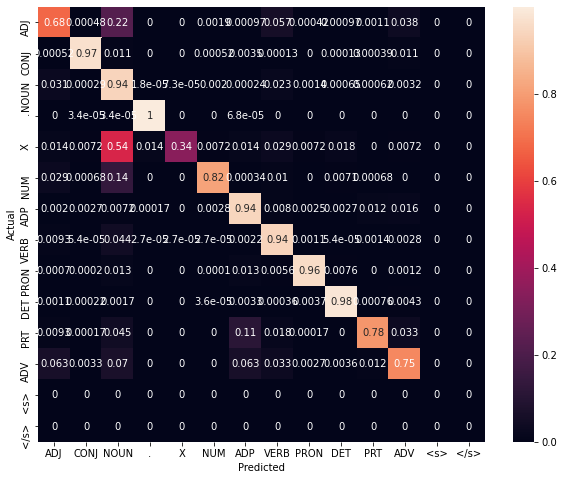

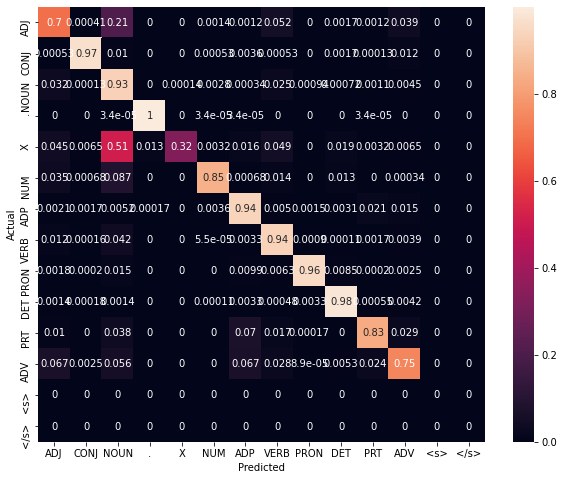

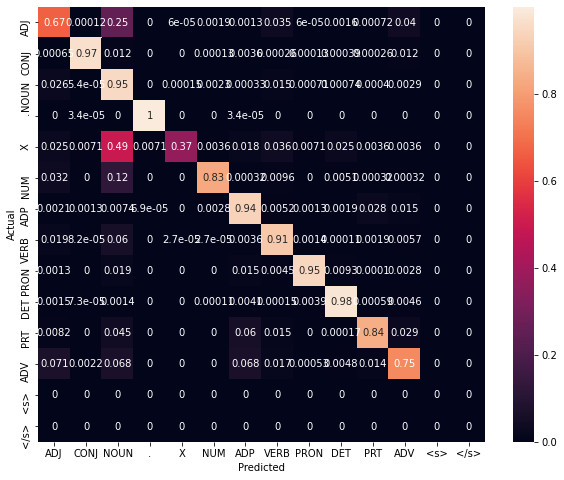

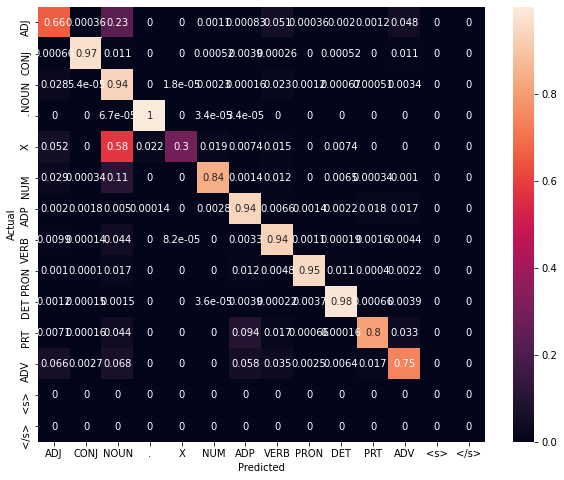

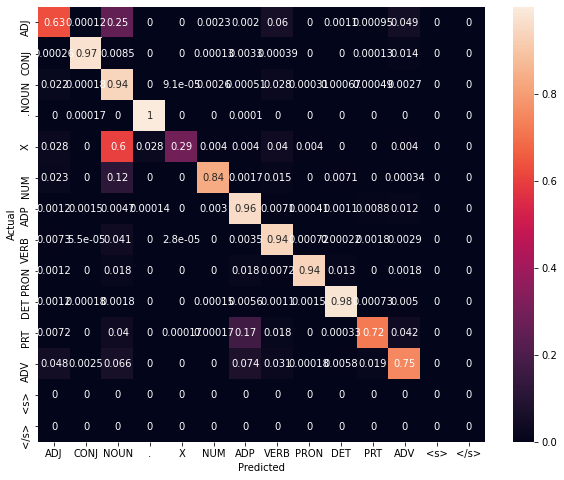

In [29]:

for cm in confusions:  
    for i in range(12):
        s=sum(cm[i])
        for k in range(12):
            cm[i][k]=cm[i][k]/s
    cm_df = pd.DataFrame(cm,tags_plot,tags_plot)            
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.figure(figsize=(10,8))  
    sns.heatmap(cm_df, annot=True)